# Feature Selection

In this section we will discuss some preprocessing that we did on the final dataset as well as the steps we took to select features that we could use for building our regression models.

In [1]:
# importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# reading our final dataset
data = pd.read_csv('./intermediate/final_data_useful_gte_10.csv')
data.head()

,stars,useful,funny,cool,recency,frequency,monetary_value,elapsed_days,day_of_week,month,...,ratio_negative_reviews,immediacy_index,review_count,useful_user,activity_length,fans,average_stars,elite_count,no_friends,helpfulness_score
0,5,11,5,8,3,686,6.861856,1884,0,11,...,0.100000,0.050000,2272,15105,4002,379,4.10,6,1257,0.095652
1,5,13,6,5,293,21,5.300000,4170,4,8,...,0.121053,0.021053,38,217,3275,4,3.69,0,60,0.043046
2,4,11,4,9,5,771,6.861856,1570,0,10,...,0.088235,0.132353,2272,15105,4002,379,4.10,6,1257,0.268293
3,4,10,6,5,35,206,2.907407,3611,3,3,...,0.086331,0.007194,324,999,1799,20,2.70,4,100,0.008945
4,4,12,11,11,0,5,20.510373,5012,2,4,...,0.186885,0.011475,793,19181,1816,290,3.58,3,758,0.030612


In [3]:
data.shape

(46623, 36)

## Analysing Helpfulness Score

On plotting the histogram of our target variable i.e. `helpfulness_score` we noticed that is positively skewed

<AxesSubplot:>

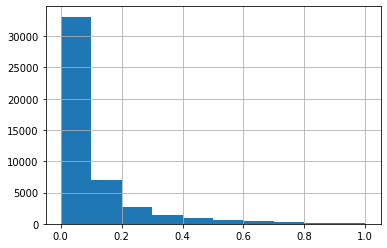

In [4]:
data['helpfulness_score'].hist()

plotting cube root transformed scores

(array([ 1240.,  8128., 12699.,  9847.,  6207.,  3614.,  2134.,  1384.,
          881.,   489.]),
 array([0.09026071, 0.18123464, 0.27220857, 0.3631825 , 0.45415643,
        0.54513036, 0.63610429, 0.72707821, 0.81805214, 0.90902607,
        1.        ]),
 <BarContainer object of 10 artists>)

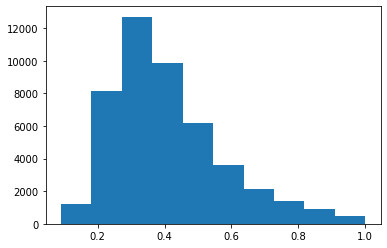

In [5]:
plt.hist(data['helpfulness_score'] ** .33)

storing cube root transformed data for further use

In [6]:
data['helpfulness_score_cbrt'] = data['helpfulness_score'] ** .33

In [7]:
data.to_csv('./data.csv', index=False)

## Feature Selection

We begin with reading the feature and target variable data in `X` and `y`

In [7]:
feature_variables = ['stars', 'recency', 'frequency', 'monetary_value', 'elapsed_days', 'polarity_score', 'subjectivity_score', 'no_of_nouns', 'no_of_sentences', 'words_per_sentence', 'automated_readability_index', 'coleman_liau_index', 'no_difficult_words', 'stars_restaurant', 'total_reviews', 'elapsed_days_restaurant', 'ratio_positive_reviews', 'ratio_negative_reviews', 'positive_reviews', 'negative_reviews', 'immediacy_index', 'review_count', 'useful_user', 'activity_length', 'fans', 'average_stars', 'elite_count', 'no_friends']

target_variable = 'helpfulness_score_cbrt'

X, Y = data[feature_variables], data[target_variable]

In [8]:
X.shape

(46623, 28)

splitting the data in traing and test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### 1. Variance Threshold

removing features with variance >= 0.05

In [10]:
var_thres = VarianceThreshold(threshold=0.05)
var_thres.fit(X_train / X_train.mean())
mask = var_thres.get_support()
X_train = X_train.loc[:, mask]
X_train.head()

,stars,recency,frequency,monetary_value,elapsed_days,polarity_score,no_of_nouns,no_of_sentences,words_per_sentence,automated_readability_index,...,ratio_negative_reviews,positive_reviews,negative_reviews,immediacy_index,review_count,useful_user,activity_length,fans,elite_count,no_friends
27601,5,0,109,6.823899,1759,0.416667,7,7,11.714286,4.0,...,0.126935,265.0,41.0,0.013932,375,2575,2757,82,8,422
16083,3,4,64,7.414634,1018,0.207639,8,11,14.818182,6.5,...,0.763158,13.0,58.0,0.026316,337,2636,4123,83,6,162
21167,4,14,140,13.367257,2248,0.235841,26,12,20.250000,7.3,...,0.151376,165.0,33.0,0.018349,741,9874,1868,543,7,3930
29570,4,12,256,2.932384,423,0.316073,22,30,12.566667,3.9,...,0.062992,110.0,8.0,0.035433,429,1285,2432,45,8,227
24761,4,13,45,2.791304,1418,0.314760,11,12,16.833333,8.7,...,0.061863,1238.0,91.0,0.002719,154,432,2878,19,7,214


In [11]:
X_train.shape

(37298, 25)

### 2. Correlated Features

Next we remove the features which are highle correlated. We use threshold as 0.9 for our case. Any feature with Pearson Correlation Coeffecient more than 0.9 were removed. In our case they were `positive_reviews` and `ratio_negative_reviews`

In [12]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.9)

len(set(corr_features))

2

In [13]:
corr_features

{'positive_reviews', 'ratio_negative_reviews'}

In [14]:
X_train = X_train.drop(corr_features, axis=1)
X_train.shape

(37298, 23)

### 3. Mutual Information

We used mutual information score to select the feature that added more explanation power to our regressor

In [15]:
# determine the mutual information
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info

stars                          0.027565
recency                        0.016087
frequency                      0.050073
monetary_value                 0.080573
elapsed_days                   0.033113
polarity_score                 0.003878
no_of_nouns                    0.001604
no_of_sentences                0.004401
words_per_sentence             0.005864
automated_readability_index    0.001373
coleman_liau_index             0.000000
no_difficult_words             0.009158
total_reviews                  1.072271
elapsed_days_restaurant        0.548114
ratio_positive_reviews         0.536359
negative_reviews               0.722980
immediacy_index                1.075253
review_count                   0.055149
useful_user                    0.082857
activity_length                0.053334
fans                           0.083800
elite_count                    0.038986
no_friends                     0.057974
dtype: float64

plotting mutual information scores

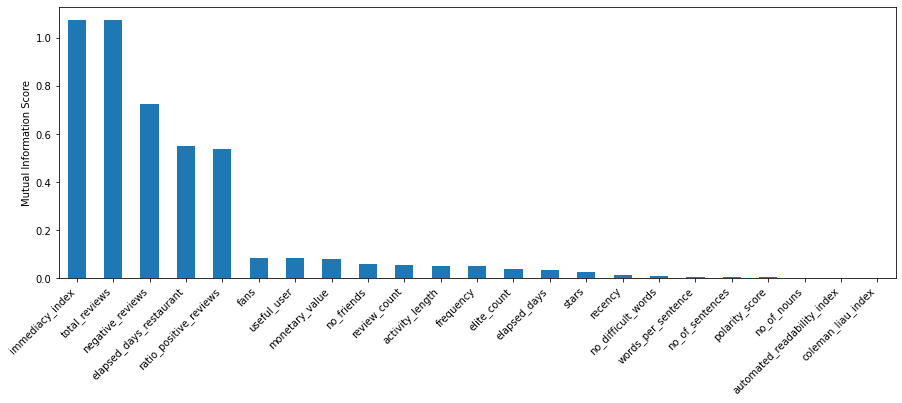

In [16]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45, ha='right')
plt.show()

selecting top 20th percentile of the features for the final consideration

In [17]:
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=20)
selected_top_columns.fit(X_train.fillna(0), y_train)

SelectPercentile(percentile=20,
                 score_func=<function mutual_info_regression at 0x7fe54bc2d170>)

In [18]:
X_train.columns[selected_top_columns.get_support()]

Index(['total_reviews', 'elapsed_days_restaurant', 'ratio_positive_reviews',
       'negative_reviews', 'immediacy_index'],
      dtype='object')

`total_reviews`, `elapsed_days_restaurant`, `ratio_positive_reviews`, `negative_reviews` and `immediacy_index` are the feature that have highers mutual information score. Hence, we will be using these set of 5 features for building our regressors.